# Camera to Machine Calibration
This notebook steps you through the calibration the pixel-space of the camera with the real-world machine coordinates, so that Jubilee can accurately move to a point in an image. Adapted with credit to Matthew Sorensen https://github.com/matthewsorensen/jubileeautofocus

### 0. Notebook Setup

In [9]:
# import required modules
import sys
sys.path.append('..')
import os
import numpy as np
import time
import math
import json
import ipywidgets as widgets
# import ipympl


import cv2
from utils.MachineUtils import *
from utils.CameraUtils import * 
from utils.CameraMachineCalibration import *

In [10]:
# Setup your machine connection
# List available ports in thie cell

ports = serial.tools.list_ports.comports()
print([port.name for port in ports]) 

['ttyACM0', 'ttyAMA0']


In [11]:
# Choose the correct port from above and establish connection with machine
port = '/dev/ttyACM0'
m = MachineCommunication(port)

In [ ]:
# Use the config file for our current machine hardware
def search_up_dirs(target_dir, max_cycles):
    n = 0
    while n != max_cycles:
        curr_folder = os.path.basename(os.path.normpath(os.getcwd()))
        if curr_folder == target_dir:
            break
        os.chdir('..')
        n = n + 1
        
search_up_dirs('duckbot', 5) #Shift to duckbot
os.chdir('ConfigFiles')
labware_config_file_dir = os.path.join(os.getcwd(),'HardwareLabwareConfigs')
os.chdir(labware_config_file_dir)
config_opts = os.listdir(os.getcwd())
hl_choice = widgets.Dropdown(options = config_opts)
display(hl_choice)

In [ ]:
with open(hl_choice.value,'r') as datafile:
    hardwarelabwareconfig = json.load(datafile)
    
tool_positions = hardwarelabwareconfig['tool_positions']
print(tool_positions)

### 1. Home your machine
Make sure the build plate is clear!

In [ ]:
m.homeAll()

### 2. Set your height for calibration
This procedure calibrates *for a particular z height*. You should choose the best height for the images you want to take on your machine. 

In [ ]:
m.toolChange(tool_positions['camera'])

In [ ]:
# change this height depending on your application
# for this example, we will be calibrating at height of z=10, for close imaging of individual well plates
m.moveTo(z=10)

### 3. Print a calibration circle
We will use a printed circle to conduct the calibration. Move the camera over an open spot on your bed and focus the camera. Then, determine a suitable size circle to print out which fits within the resulting picture. 
ToDo: link to illustrator/inkscape file to make the circle, or make it directly here in jupyter

In [16]:
# move to an open spot on the bed
m.moveTo(x=85.8, y=245)

In [21]:
# focus the camera
# choose the correct video device if you have >1 camera
# center the tool under the microscope
# make note of the x,y coordinates
cap = cv2.VideoCapture(0) #Note that the index corresponding to your camera may not be zero but this is the most common default

# draw a circle in the center of the frame
center = None
while center is None:
    # the first frame grab is sometimes empty
    ret, frame = cap.read()
    h, w = frame.shape[0:2]
    center = (int(w/2), int(h/2))
    print(center)

while True:
    ret, frame = cap.read()
    target = cv2.circle(frame, center, 5, (0,255,0), -1)
    cv2.imshow('Input', frame)
    c = cv2.waitKey(1)
    if c ==27: #27 is the built in code for ESC so press escape to close the window. 
        break 
        
cap.release()
cv2.destroyAllWindows()

(320, 240)


In [ ]:
# It's important that your calibration circle doesn't move during the calibration process
# Print a circle at a size suitable for your z height, and tape it to the bed plate

## 4. Find the size of the printed circle in pixels
To accurately detect the circle, we'll find the radius of the circle in pixels

I used a gain of 1.2000000000000002
the radius is: 262
the center is: (602,601)
I found 1 wells


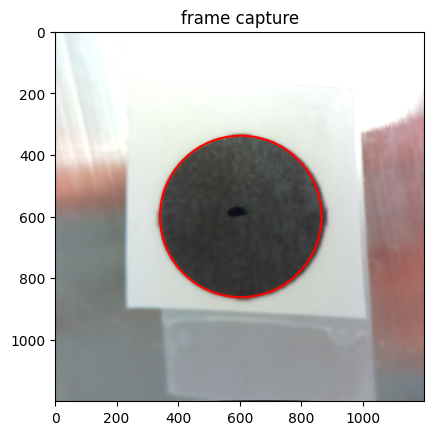

In [20]:
%matplotlib inline 


# take a picture
f = getFrame()

# Try finding a single circle in the image
# If the circle is much bigger or smaller than the bounds here, change them until a single circle is found
circle, circleData = getSingleWell(f, minR = 0, maxR = 500)
showFrame(circle)

In [6]:
# set the min and max radius bounds based on the results above
tolerance = 5
circleRadius = circleData[0][2] # circle data returns a list of (center_x, center_y, radius) coordinates
min_radius = circleRadius - tolerance
max_radius = circleRadius + tolerance
min_radius

270

### 5. Run the calibration
Using the parameters set above, we can now run the calibration procedure!

In [7]:
#position = m.getPosition()
#print(position)
calibrate_camera_machine(m, 10, min_radius, max_radius)

...camera connection established
Moving to focus
the raw response is: ok

now im returning: {'X': '83.900', 'Y': '244.500', 'Z': '10.000', 'U': '0.000', 'E': '0.000', 'E0': '-0.0', 'E1': '-0.0'}
position: {'X': '83.900', 'Y': '244.500', 'Z': '10.000', 'U': '0.000', 'E': '0.000', 'E0': '-0.0', 'E1': '-0.0'}
xy is (83.9, 244.5)
Begining rough pass
x is 82.41384041451204, y is 241.39201153978004
I used a gain of 1.9000000000000008
Data point: 82.41384041451204,241.39201153978004 vs. -0.011541697184244804,0.013791656494140603
x is 81.99512534732465, y is 241.6047235199939
I used a gain of 2.000000000000001
Data point: 81.99512534732465,241.6047235199939 vs. -0.11916666666666664,0.0641666666666667
x is 84.9120451082067, y is 240.65068692273704
I used a gain of 2.100000000000001
Data point: 84.9120451082067,240.65068692273704 vs. -0.09312502543131512,0.07312494913736978
x is 88.88636761683324, y is 245.64869055637067
I used a gain of 1.9000000000000008
Data point: 88.88636761683324,245.64869

KeyboardInterrupt: 

### 6. Check Calibration
We can move to a few points to confirm that the calibration looks good!
ToDo: file organization, where the calibration file gets written to

In [ ]:
# loads in the relevant calibration files

with open("/home/pi/duckbot/notebooks/calibration/camera_cal_z_10.json") as f:
    cal = json.load(f)
matrix = np.array(cal['transform'])
size = cal['resolution']
print(matrix)
print(size)

m.transform = matrix
m.img_size = size

# convert px coord to real coord
def px_to_real(x,y, absolute = False):
        x = (x / m.img_size[0]) - 0.5
        y = (y / m.img_size[1]) - 0.5
        a = 1 if absolute else 0

        return (m.transform.T @ np.array([x**2, y**2, x * y, x, y, a]))

In [ ]:
# move to the center of the calibration circle
center = m.transform.T @ np.array([0, 0, 0, 0, 0, 1])
m.moveTo(x=center[0], y=center[1])

In [ ]:
# check position
showFrame(getFrame())

In [ ]:
# ToDo: can't switch backends mid notebook for inline/gui  
f = getFrame()
pts = selectPoint(f, num_pts=3)

In [ ]:
for pt in pts:
    off = px_to_real(pt[0], pt[1])
    m.moveTo(x=center[0]-off[0], y=center[1]-off[1])
    showFrame(getFrame(), grid=True)
    input()

In [ ]:
### Testing Syringe Alignment
m.moveTo(z=50)
m.toolChange(3)

In [ ]:
m.moveTo(x=center[0], y=center[1])

In [ ]:
syringe_off = [-0.3, 1.1]

In [ ]:
m.moveTo(x=center[0] + syringe_off[0], y=center[1]+syringe_off[1])

In [ ]:
# fnum = 1

In [ ]:
f = getFrame()

In [ ]:
print(fnum)
showFrame(f)
print(fnum)

In [ ]:
saveFrame(f, f"/home/pi/Downloads/pscope-polar-walk-{fnum}.png")
fnum += 1